In [1]:
import numpy as np
import matplotlib
import pickle
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

import os
os.chdir("../../scVI/")
os.getcwd()
save_path = '../CSF/Notebooks/'

In [2]:
latent_u = np.load(save_path + 'UMAP/all_dataset.umap.npy')
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltype, labels = np.unique(celllabels, return_inverse=True)
isMS = np.load(save_path+'meta/isMS.npy')
isCSF = np.load(save_path+'meta/isCSF.npy')
validclusters = (celllabels!='Mono Doublet') & \
(celllabels!='contamination1') & \
(celllabels!='doublet') & \
(celllabels!='B cell doublets') & \
(celllabels!='RBC')

In [3]:
colors = ['#ff0000', '#e30000', '#c70000', '#732b20', '#c7601c', '#ff9924', '#735210', '#ab9f00', '#eeff00', '#2b5724', '#1cc749', '#1cc7a5', '#5fc9e3', '#24b6ff', '#205773', '#3061ab', '#001f73', '#6b7fff', '#601cc7', '#8f3c89', '#ff24d3', '#570023', '#ff4778']


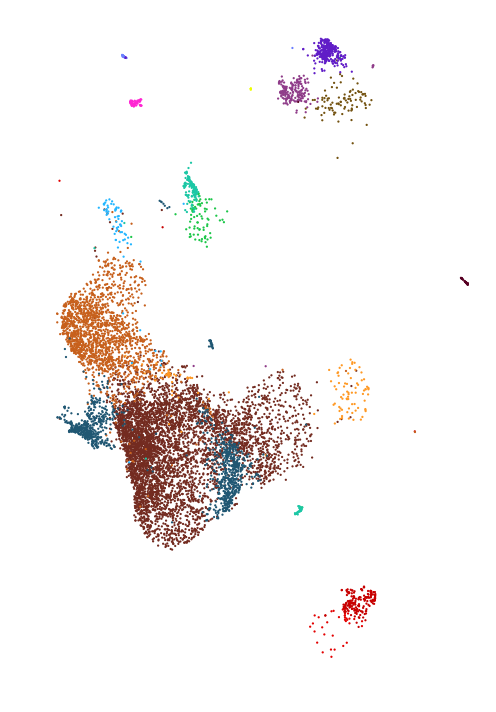

In [4]:

fig, ax = plt.subplots(figsize=(7, 10))

for i,x in enumerate(np.unique(celllabels)):
    if (x != 'contamination1') and (x!='doublet') and (x!='Mono Doublet') and (x!='B cell doublets') and (x!='RBC'):
        idx = (celllabels==x)*isCSF*isMS
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',c=colors[i],s=5)
#         ax.text(mean_pos[i][0]+1, mean_pos[i][1], x, fontsize=30,color=colors[i])
        
plt.axis("off")
plt.tight_layout()
plt.savefig(save_path+'figures/Figure2/cluster_umap.MS_CSF.png',dpi=300)


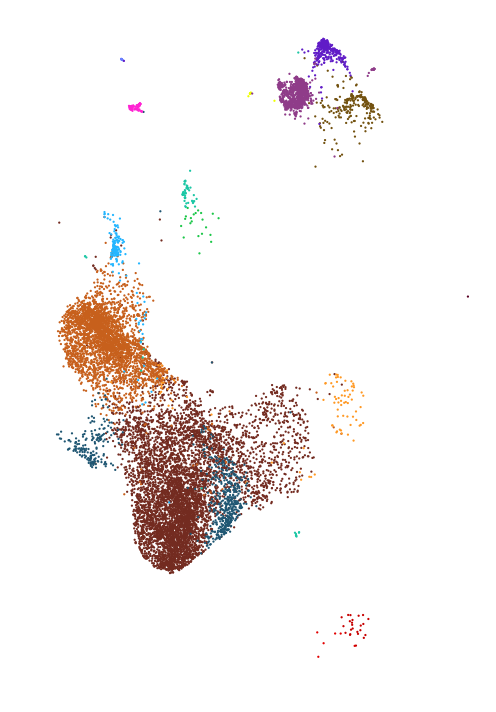

In [5]:

fig, ax = plt.subplots(figsize=(7, 10))

for i,x in enumerate(np.unique(celllabels)):
    if (x != 'contamination1') and (x!='doublet') and (x!='Mono Doublet') and (x!='B cell doublets') and (x!='RBC'):
        idx = (celllabels==x)*isCSF*(isMS==False)
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',c=colors[i],s=5)
#         ax.text(mean_pos[i][0]+1, mean_pos[i][1], x, fontsize=30,color=colors[i])
        
plt.axis("off")
plt.tight_layout()
plt.savefig(save_path+'figures/Figure2/cluster_umap.control_CSF.png',dpi=300)


In [9]:
with open(save_path + 'DE/MSinCSF.DEres.pkl', 'rb') as f:
    CSF_DE,CSF_DEclust = pickle.load(f)

with open(save_path + 'DE/MSinPBMC.DEres.pkl', 'rb') as f:
    PBMC_DE,PBMC_DEclust = pickle.load(f)

shared =[x for x in PBMC_DEclust if x in CSF_DEclust ]

CSF_DE = [ x for i,x in enumerate(CSF_DE) if CSF_DEclust[i] in shared]
PBMC_DE = [ x for i,x in enumerate(PBMC_DE) if PBMC_DEclust[i] in shared]

In [10]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltypes = np.unique(celllabels)

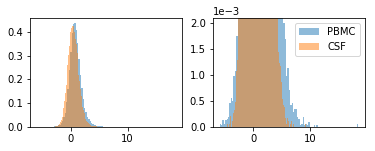

In [14]:
temp2 = pd.concat(CSF_DE)
temp1 = pd.concat(PBMC_DE)

plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
_ = plt.hist(temp1['bayes1'],100,alpha=0.5,density=True,label='PBMC')
_ = plt.hist(temp2['bayes1'],100,alpha=0.5,density=True,label='CSF')
plt.subplot(1,2,2)
_ = plt.hist(temp1['bayes1'],100,alpha=0.5,density=True,label='PBMC')
_ = plt.hist(temp2['bayes1'],100,alpha=0.5,density=True,label='CSF')
plt.legend()
plt.ylim(0,0.0021)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,2))
plt.savefig(save_path+'figures/Figure2/Bayes_comparision.pdf')

In [15]:
with open(save_path + 'dataset/all_datasets.pkl', 'rb') as f:
    gene_dataset = pickle.load(f)

# logX = np.log10(1+gene_dataset.X.todense())
# scaling_factor = logX.mean(axis=1)
# norm_X = logX - scaling_factor.reshape(len(scaling_factor), 1)
# norm_X = 10**np.asarray(norm_X)-1

X = gene_dataset.X.todense()
scaling_factor = X.mean(axis=1)
norm_X = X/scaling_factor.reshape(len(scaling_factor), 1)


labels = np.load(save_path + 'meta/CD4.clusters.npy')
celltypes = np.unique(labels).astype(str)

celllabels = np.load(save_path + 'meta/celllabels.npy')
isCD4 = celllabels=='CD4'
CD4labels = np.repeat(-1,len(celllabels))
CD4labels[isCD4] = labels

In [45]:
def DotPlotCompare(norm_X, genenames, genelist, clusterlabel, group, filt,dotsize=500,labelnames=None,
                   filename=None,save_path=save_path+'figures/',
                  height=5,width=5):
    exprs = [norm_X[:,genenames==x] for x in genelist]
    exprs = np.asarray(exprs).squeeze()
    exprs = exprs / exprs.max(axis=1).reshape(len(genelist),1)
    exprs = pd.DataFrame(exprs.T, columns=genelist)
    exprs = exprs.loc[filt]
    clusterlabel = clusterlabel[filt]
    group = group[filt]
    mean_exprs = []
    clustercol = []
    groupcol = []
    colname = []
    if labelnames is None: 
        labelnames = np.unique(clusterlabel)
    for x in labelnames:
        for y in np.unique(group):
            if np.sum((clusterlabel==x)&(group==y))>0:
                avg=exprs.loc[(clusterlabel==x)&(group==y)].mean(axis=0)
                mean_exprs.append(np.log10(1+avg))
                colname.append(str(x)+'_'+str(y))
                clustercol.append(x)
                groupcol.append(y)
    mean_exprs = pd.concat(mean_exprs,axis=1)
    mean_exprs.columns = colname
    mean_exprs['genenames'] = mean_exprs.index
    temp = mean_exprs.melt(id_vars=['genenames'], value_vars=colname)
    temp['group'] = [x.split('_')[1] for x in temp['variable']]
    temp['cluster'] = [x.split('_')[0] for x in temp['variable']]
    groupname,temp['groupid'] = np.unique(temp['group'],return_inverse=True)
    genes = np.unique(temp['genenames'])
    temp['clusterid'] = [labelnames.index(x) for x in temp['cluster']]
    temp['geneid'] = [genelist.index(x) for x in temp['genenames']]
#     np.unique(temp['genenames'],return_inverse=True)
    plt.figure(figsize=(width*2,height))
    plt.subplot(1,2,1)
    plt.scatter(x=temp.loc[temp['groupid']==1]['geneid'],
                y=temp.loc[temp['groupid']==1]['clusterid'],
                s=temp.loc[temp['groupid']==1]['value']*dotsize*100,
                c='m',alpha=0.5,label=groupname[1])
    plt.scatter(x=temp.loc[temp['groupid']==0]['geneid'],
                y=temp.loc[temp['groupid']==0]['clusterid'],
                s=temp.loc[temp['groupid']==0]['value']*dotsize*100,
                c='c',alpha=0.5,label=groupname[0])
    plt.xticks(ticks=np.arange(len(genes)), labels=genelist, rotation=90)
    plt.yticks(ticks=np.arange(len(labelnames)), labels=labelnames)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.subplot(1,2,2)
    for area in [0.01, 0.05, 0.1]:
        plt.scatter([], [], c='k', s=area*dotsize*100,
                    label=str(area))
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='log10 Expression')
    plt.axis('off')
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
    return temp


In [46]:
bloodlist = ['PECAM1', 'ITGA5', 'IL17RA','ICOS','CLEC2D', 'LITAF','GRN', 'GZMA', 'KLRF1', 'IRF9', 'EOMES','STAT3', 'STAT4', 'MAF1','JUNB',  'NFATC1']
csflist = ['IL12RB1', 'IL18RAP', 'TNFRSF18', 'HLA-C', 'CD5', 'CD74', 'ITGB1', 'STAT1', 'MUM1', 'IRF3','IRF7', 'IRF8', 'STAT5A','JUN', 'HIF1A']


In [47]:
np.unique(isMS)

array([False,  True])

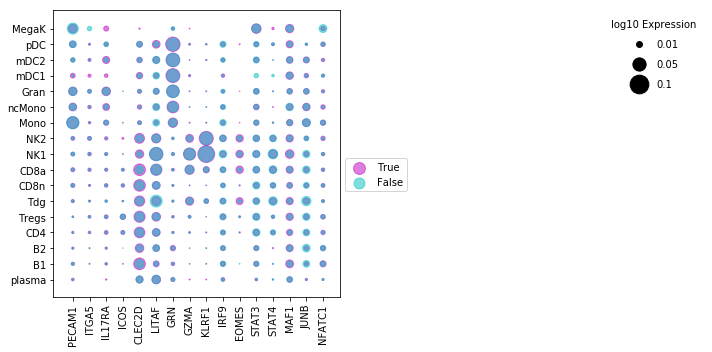

In [48]:
scale=.5
temp = DotPlotCompare(norm_X, gene_dataset.gene_names, 
            bloodlist, celllabels, isMS,validclusters*(isCSF==False),
            labelnames=['plasma','B1','B2','CD4','Tregs','Tdg','CD8n','CD8a','NK1','NK2','Mono','ncMono','Gran','mDC1','mDC2','pDC','MegaK'],
            dotsize=140*scale**2,filename=save_path+'figures/Figure2/bloodMS.pdf',
            height=10*scale,width=10*scale)

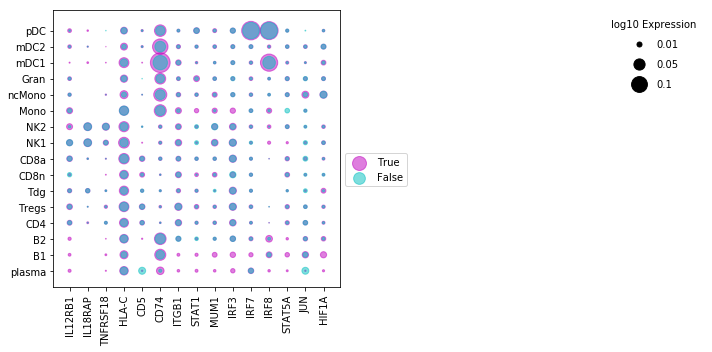

In [50]:
temp = DotPlotCompare(norm_X, gene_dataset.gene_names, 
            csflist, celllabels, isMS,validclusters*(isCSF==True),
            labelnames=['plasma','B1','B2','CD4','Tregs','Tdg','CD8n','CD8a','NK1','NK2','Mono','ncMono','Gran','mDC1','mDC2','pDC'],
            dotsize=100*scale**2,filename=save_path+'figures/Figure2/csfMS.pdf',
            height=10*scale,width=10*scale)
